# Computing Heterogenous Agent Jacobians in HARK

By William Du

This notebook illustrates how to compute Heterogenous Agent Jacobian matrices in HARK.

These matrices are a fundamental building building block to solving Heterogenous Agent New Keynesian Models with the sequence space jacobian methodology. For more information, see [Auclert, Rognlie, Bardoszy, and Straub (2021)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434)

For the IndShockConsumerType, Jacobians of Consumption and Saving can be computed with respect to the following parameters:
LivPrb, PermShkStd,TranShkStd,UnempPrb, Rfree, IncUnemp.

In [1]:
from time import time
import matplotlib.pyplot as plt

from HARK.ConsumptionSaving.ConsNewKeynesianModel import (
    NewKeynesianConsumerType,
)
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [2]:
# Define a simple function for plotting SSJs
def plot_SSJ(jac, S, outcome, shock):
    if type(S) is int:
        S = [S]
    for s in S:
        plt.plot(jac[:, s], "-", label="s=" + str(s))
    plt.legend()
    plt.xlabel(r"time $t$")
    plt.ylabel("rate of change of " + outcome)
    plt.title("SSJ for " + outcome + " with respect to " + shock + r" at time $s$")
    plt.tight_layout()
    plt.xlim(-1, jac.shape[0] + 1)
    plt.show()


S_set = [0, 10, 30, 60]  # list of s indices to plot

## Create Agent

In [3]:
# Make mNrm grid linear to match new method
base_params = {
    "mFac": -1,
    "tolerance": 1e-9,
}

# Dictionary for IndShockConsumerType to match defaults of NewKeynesianConsumerType
alt_params = {
    "PermGroFac": [1.0],
    "aXtraMax": 50.0,
    "aXtraCount": 100,
    "DiscFac": 0.96,
    "tolerance": 1e-9,
    "cycles": 0,
}

swap_params = {
    "DiscFac": 0.94,
    "LivPrb": [0.9999],
}

# Turn this on to see what happens when we turn up survival and down discounting (offsetting)
if False:
    base_params.update(swap_params)
    alt_params.update(swap_params)

# Make a dictionary of grid specifications for the new version
assets_grid_spec = {"min": 0.0, "max": 50.0, "N": 201}
consumption_grid_spec = {"min": 0.0, "max": 5.0, "N": 151}
my_grid_specs = {"kNrm": assets_grid_spec, "cNrm": consumption_grid_spec}

In [4]:
Agent = NewKeynesianConsumerType(**base_params)  # use mostly sdefault parameters
AltAgent = IndShockConsumerType(**alt_params)  # adjust to match defaults of ^^

## Compute Steady State

In [5]:
start = time()
Agent.compute_steady_state()
print("Seconds to compute steady state", time() - start)

timestonest is -1
Seconds to compute steady state 11.243927240371704


## Compute Jacobians

Shocks possible: LivPrb, PermShkStd,TranShkStd, DiscFac,UnempPrb, Rfree, IncUnemp

### Shock to Standard Deviation to Permanent Income Shocks

In [6]:
start = time()

CJAC_Perm, AJAC_Perm = Agent.calc_jacobian("PermShkStd", 300)

print("Seconds to calculate Jacobian", time() - start)

timestonest is -1
timestonest is -1
Seconds to calculate Jacobian 4.8951027393341064


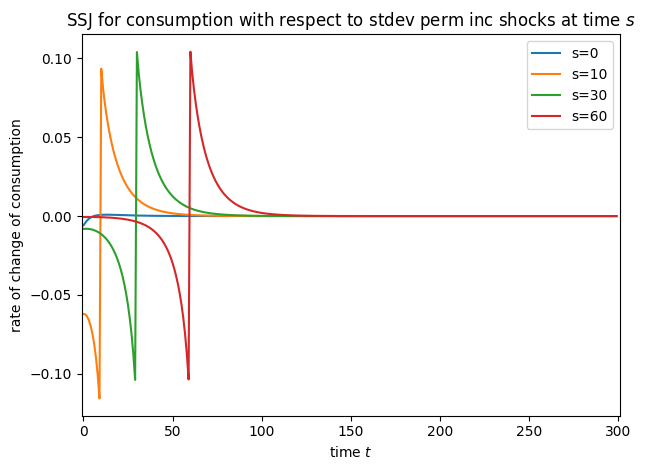

In [7]:
plot_SSJ(CJAC_Perm, S_set, "consumption", "stdev perm inc shocks")

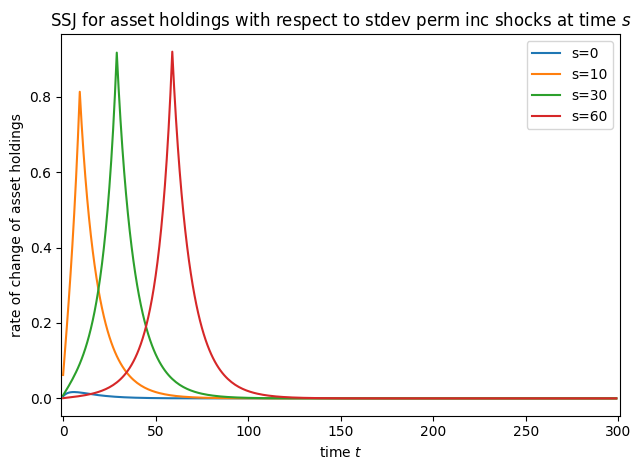

In [8]:
plot_SSJ(AJAC_Perm, S_set, "asset holdings", "stdev perm inc shocks")

#### Do the same thing with the new version and plot the differences

In [9]:
# Compute the SSJs and time it
t0 = time()
SSJ_A_sigma_psi, SSJ_C_sigma_psi = AltAgent.make_basic_SSJ(
    "PermShkStd",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 6.298 seconds in total.


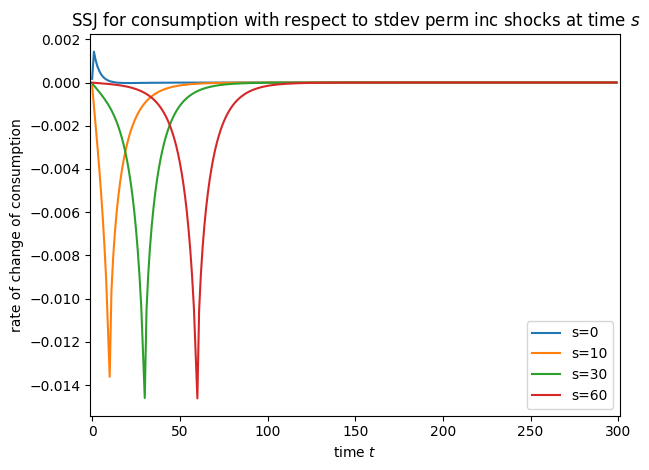

In [10]:
plot_SSJ(SSJ_C_sigma_psi - CJAC_Perm, S_set, "consumption", "stdev perm inc shocks")

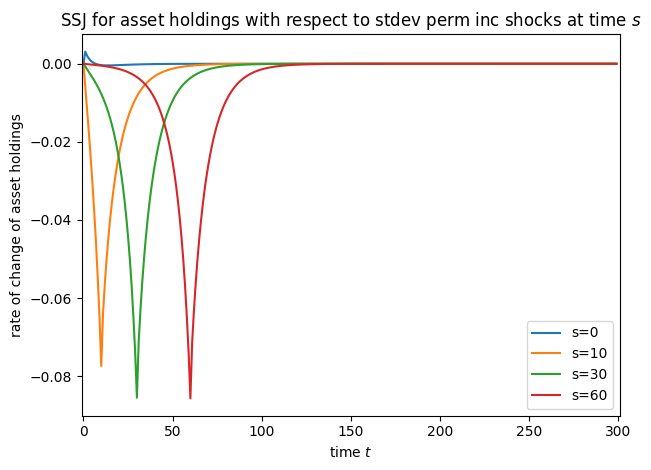

In [11]:
plot_SSJ(SSJ_A_sigma_psi - AJAC_Perm, S_set, "asset holdings", "stdev perm inc shocks")

### Shock to Real Interest Rate

In [12]:
CJAC_Rfree, AJAC_Rfree = Agent.calc_jacobian(
    "Rfree", 300
)  # compute Jacobian using old method

timestonest is -1
timestonest is -1


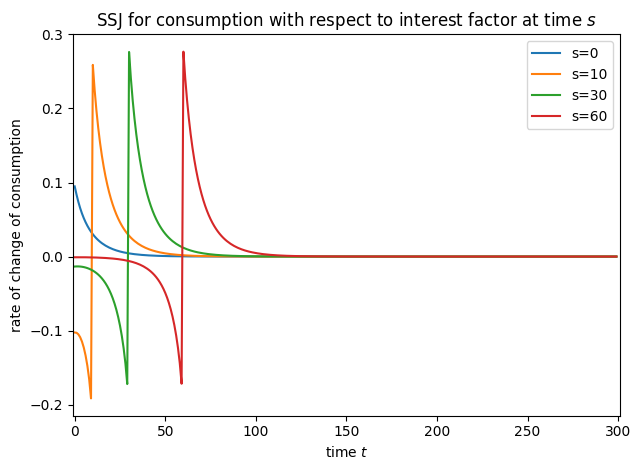

In [13]:
plot_SSJ(CJAC_Rfree, S_set, "consumption", "interest factor")

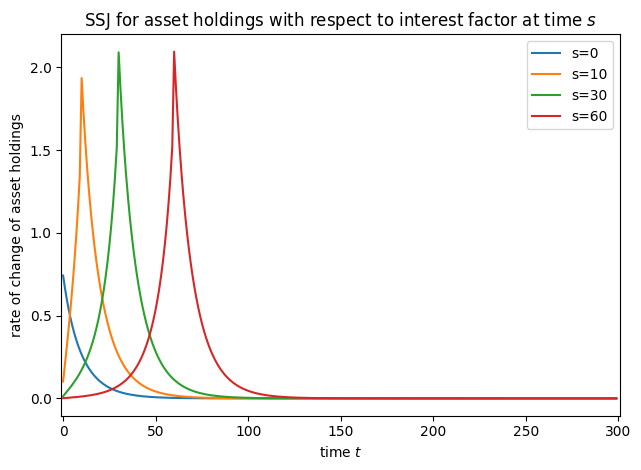

In [14]:
plot_SSJ(AJAC_Rfree, S_set, "asset holdings", "interest factor")

#### Do the same thing with the new version and plot the differences

In [15]:
# Compute the SSJs and time it
t0 = time()
SSJ_A_r, SSJ_C_r = AltAgent.make_basic_SSJ(
    "Rfree",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
    solved=True,
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 4.430 seconds in total.


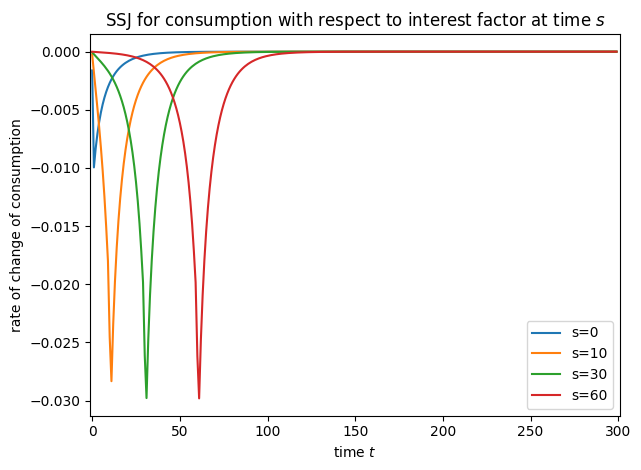

In [16]:
plot_SSJ(SSJ_C_r - CJAC_Rfree, S_set, "consumption", "interest factor")

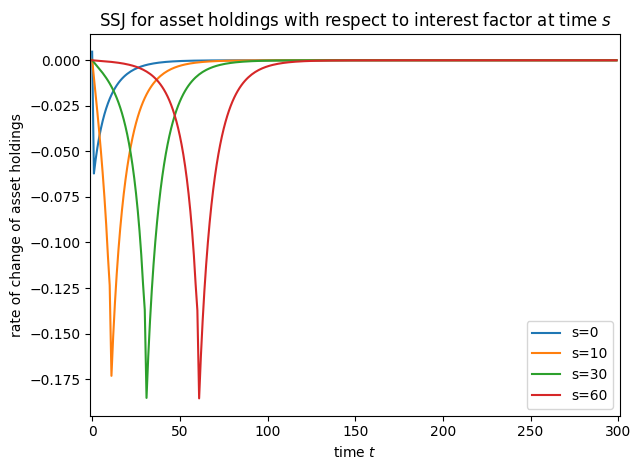

In [17]:
plot_SSJ(SSJ_A_r - AJAC_Rfree, S_set, "asset holdings", "interest factor")

### Shock to Unemployment Probability

In [18]:
CJAC_UnempPrb, AJAC_UnempPrb = Agent.calc_jacobian(
    "UnempPrb", 300
)  # make SSJs using old method

timestonest is -1
timestonest is -1


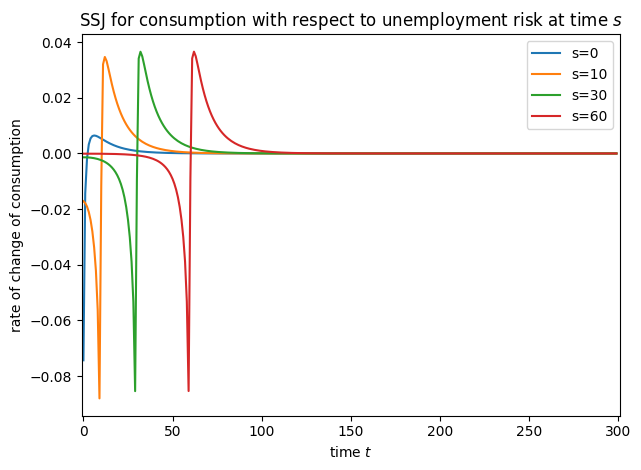

In [19]:
plot_SSJ(CJAC_UnempPrb, S_set, "consumption", "unemployment risk")

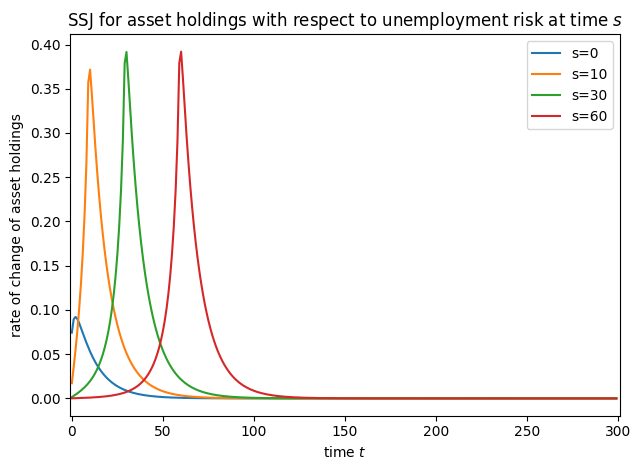

In [20]:
plot_SSJ(AJAC_UnempPrb, S_set, "asset holdings", "unemployment risk")

#### Do the same thing with the new version and plot the differences

In [21]:
# Compute the SSJs and time it
t0 = time()
SSJ_A_U, SSJ_C_U = AltAgent.make_basic_SSJ(
    "UnempPrb",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
    solved=True,
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 4.118 seconds in total.


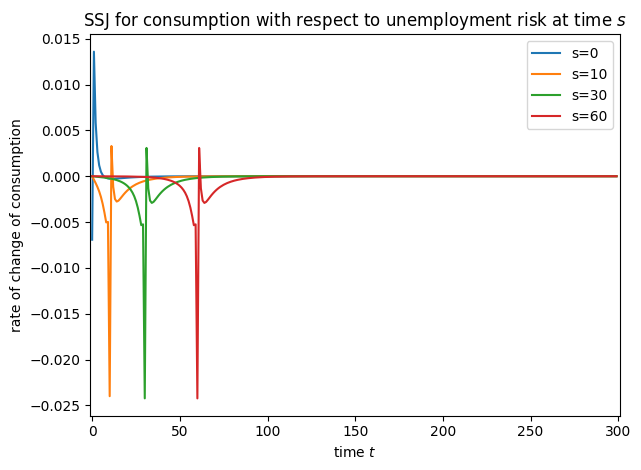

In [22]:
plot_SSJ(SSJ_C_U - CJAC_UnempPrb, S_set, "consumption", "unemployment risk")

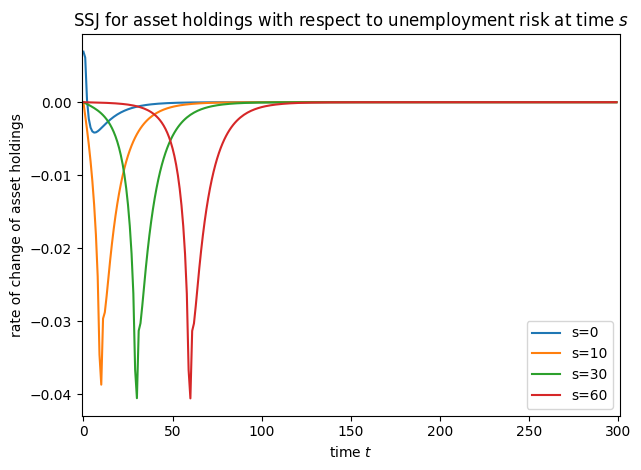

In [23]:
plot_SSJ(SSJ_A_U - AJAC_UnempPrb, S_set, "asset holdings", "unemployment risk")